In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsRegressor
import rasterio as rst
from rasterstats import zonal_stats

%matplotlib inline

In [2]:
path = r"[CHANGE THIS PATH]\NI\\"

In [3]:
data = pd.read_csv(path + "final_data.csv", index_col = 0)

# Convert to GeoDataFrame

In [4]:
geo_data = gpd.GeoDataFrame(data = data, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = data.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head()

,pcstrip,Year,Registered_Patients,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,laua,...,blood pressure_zscore,hypertension_zscore,diabeties_zscore,cardiovascular disease_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore,loneliness_zscore,loneills,geometry
0,BT100BX,2018,13136.909091,330432.0,369844.0,95GG23S3,N99999999,NaN,N99999999,N09000003,...,-0.685213,-0.719500,-0.633420,-0.634172,-0.654130,-0.14855,0.287221,-1.422309,0.709436,POINT (330432 369844)
1,BT119EA,2018,22261.909091,329737.0,371336.0,95GG01S2,N99999999,NaN,N99999999,N09000003,...,-0.318645,-0.292514,-0.553632,-0.135894,-0.501188,-0.14855,0.286684,0.000137,0.252945,POINT (329737 371336)
2,BT119FZ,2018,6928.454545,329097.0,371029.0,95GG01S1,N99999999,NaN,N99999999,N09000003,...,-0.442223,-0.504514,-0.272304,-0.591257,-0.697384,-0.14855,-0.761487,-0.323393,-0.814675,POINT (329097 371029)
3,BT124HL,2018,5078.454545,332828.0,374124.0,95GG21S2,N99999999,NaN,N99999999,N09000003,...,-1.117137,-1.153058,-1.848652,-1.352703,-0.738766,-0.14855,-0.996358,-2.234316,-4.496066,POINT (332828 374124)
4,BT124LP,2018,4267.090909,332449.0,373831.0,95GG21S1,N99999999,NaN,N99999999,N09000003,...,0.351549,0.333836,1.464017,-0.747035,0.266781,-0.14855,-0.706297,0.276605,0.893749,POINT (332449 373831)


C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


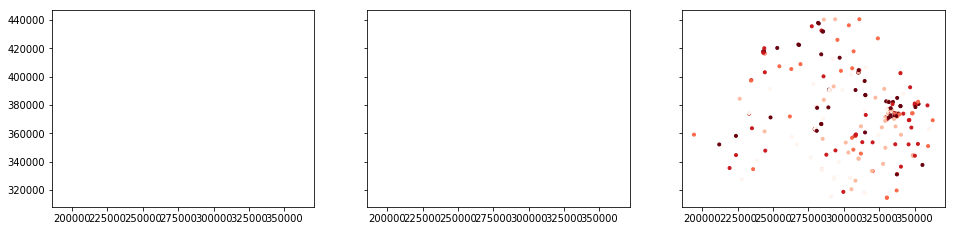

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,6), sharex = True, sharey = True)

geo_data[geo_data['Year'] == 2016].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax1);
geo_data[geo_data['Year'] == 2017].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax2);
geo_data[geo_data['Year'] == 2018].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax3);

## k-nearest neighbour interpolation

Non-parametric interpolation of loneliness based on local set of _k_ nearest neighbours for each cell in our evaluation grid.

Effectively becomes an inverse distance weighted (idw) interpolation when weights are set to be distance based.

In [6]:
def idw_model(k, p):
    def _inv_distance_index(weights, index=p):
        return (test==0).astype(int) if np.any(weights == 0) else 1. / weights**index
    return KNeighborsRegressor(k, weights=_inv_distance_index)

def grid(xmin, xmax, ymin, ymax, cellsize):
    # Set x and y ranges to accommodate cellsize
    xmin = (xmin // cellsize) * cellsize
    xmax = -(-xmax // cellsize) * cellsize # ceiling division
    ymin = (ymin // cellsize) * cellsize
    ymax = -(-ymax // cellsize) * cellsize
    # Make meshgrid
    x = np.linspace(xmin,xmax,(xmax-xmin)/cellsize)
    y = np.linspace(ymin,ymax,(ymax-ymin)/cellsize)
    return np.meshgrid(x,y)

def reshape_grid(xx,yy):
    return np.append(xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis],1)

def reshape_image(z, xx):
    return np.flip(z.reshape(np.shape(xx)),0)

def idw_surface(locations, values, xmin, xmax, ymin, ymax, cellsize, k=5, p=2):
    # Make and fit the idw model
    idw = idw_model(k,p).fit(locations, values)
    # Make the grid to estimate over
    xx, yy = grid(xmin, xmax, ymin, ymax, cellsize)
    # reshape the grid for estimation
    xy = reshape_grid(xx,yy)
    # Predict the grid values
    z = idw.predict(xy)
    # reshape to image array
    z = reshape_image(z, xx)
    return z

## 2016 data

In [ ]:
# Get point locations and values from data
# points = geo_data[geo_data['Year'] == 2016][['oseast1m','osnrth1m']].values
# vals = geo_data[geo_data['Year'] == 2016]['loneills'].values
#
# surface2016 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

In [ ]:
# Look at surface
# f, ax = plt.subplots(figsize = (8,10))
# ax.imshow(surface2016, cmap='Reds')
# ax.set_aspect('equal')

## 2017 Data

In [ ]:
# Get point locations and values from data
# points = geo_data[geo_data['Year'] == 2017][['oseast1m','osnrth1m']].values
# vals = geo_data[geo_data['Year'] == 2017]['loneills'].values
#
# surface2017 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

In [ ]:
# Look at surface
# f, ax = plt.subplots(figsize = (8,10))
# ax.imshow(surface2017, cmap='Reds')
# ax.set_aspect('equal')

## 2018 Data

Get minimum and maximum bounds from the data. Round these down (in case of the 'min's) and up (in case of the 'max's) to get the values for `idw_surface()`

In [7]:
print("xmin = ", geo_data['oseast1m'].min(), "\n\r",
      "xmax = ", geo_data['oseast1m'].max(), "\n\r",
      "ymin = ", geo_data['osnrth1m'].min(), "\n\r",
      "ymax = ", geo_data['osnrth1m'].max())

xmin =  194098.0 
 xmax =  362801.0 
 ymin =  314364.0 
 ymax =  440595.0


In [8]:
xmin = 194000
xmax = 363000
ymin = 314000
ymax = 441000

In [9]:
# Get point locations and values from data
points = geo_data[geo_data['Year'] == 2018][['oseast1m','osnrth1m']].values
vals = geo_data[geo_data['Year'] == 2018]['loneills'].values

surface2018 = idw_surface(points, vals, xmin,xmax,ymin,ymax,250,7,2)

C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


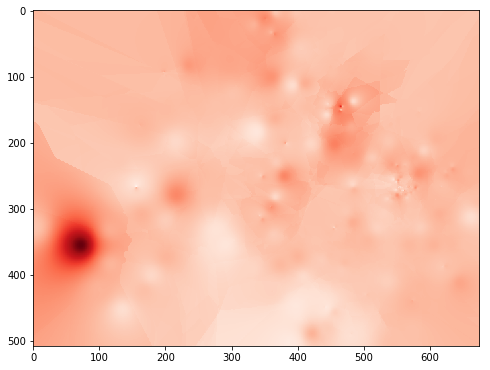

In [10]:
# Look at surface
f, ax = plt.subplots(figsize = (8,10))
ax.imshow(surface2018, cmap='Reds')
ax.set_aspect('equal')

# Extract Values to MSOAs

Get 2011 MSOAs from the Open Geography Portal: http://geoportal.statistics.gov.uk/

In [11]:
# Get MSOAs which we use to aggregate the loneills variable.
#filestring = './Data/MSOAs/Middle_Layer_Super_Output_Areas_December_2011_Full_Clipped_Boundaries_in_England_and_Wales.shp'
filestring = r'[CHANGE THIS PATH]\Data\Boundaries\NI\NI SOA 2011\SOA2011.shp'

msoas = gpd.read_file(filestring)
msoas.to_crs({'init':'epsg:27700'})

,SOA_CODE,SOA_LABEL,geometry
0,95AA01S1,Aldergrove_1,"POLYGON ((128801.7886351294 537314.4830062411,..."
1,95AA01S2,Aldergrove_2,"POLYGON ((125918.9081406117 540595.6545863295,..."
2,95AA01S3,Aldergrove_3,"POLYGON ((129346.0087089942 542233.2403820698,..."
3,95AA02W1,Balloo,"POLYGON ((127621.533542762 543998.6660082308, ..."
4,95AA03W1,Ballycraigy,"POLYGON ((130710.6071728271 542999.4230030531,..."
5,95AA04W1,Clady,"POLYGON ((138895.08423051 540699.8917459199, 1..."
6,95AA05W1,Cranfield,"POLYGON ((117987.9155373918 549114.7867712282,..."
7,95AA06S1,Crumlin_1_Antrim,"POLYGON ((127328.8869016796 533392.3847480657,..."
8,95AA06S2,Crumlin_2_Antrim,"POLYGON ((127125.7096754572 533937.9883325619,..."
9,95AA07W1,Drumanaway,"POLYGON ((121347.5933432991 553775.1327891221,..."


In [41]:
# Get GB countries data to use for representation
#gb = gpd.read_file('./Data/GB/Countries_December_2017_Generalised_Clipped_Boundaries_in_UK_WGS84.shp')
#gb = gb.to_crs({'init':'epsg:27700'})
# get England
#eng = gb[gb['ctry17nm'] == 'England'].copy()

In [13]:
# Make affine transform for raster
trans = rst.Affine.from_gdal(xmin-125,250,0,ymax+125,0,-250)

In [14]:
# NB This process is slooow - write bespoke method?
# 2016
#msoa_zones = zonal_stats(msoas['geometry'], surface2016, affine = trans, stats = 'mean', nodata = np.nan)
#msoas['loneills_2016'] = list(map(lambda x: x['mean'] , msoa_zones))
# 2017
#msoa_zones = zonal_stats(msoas['geometry'], surface2017, affine = trans, stats = 'mean', nodata = np.nan)
#msoas['loneills_2017'] = list(map(lambda x: x['mean'] , msoa_zones))
# 2018
msoa_zones = zonal_stats(msoas['geometry'], surface2018, affine = trans, stats = 'mean', nodata = np.nan)
msoas['loneills_2018'] = list(map(lambda x: x['mean'] , msoa_zones))

C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


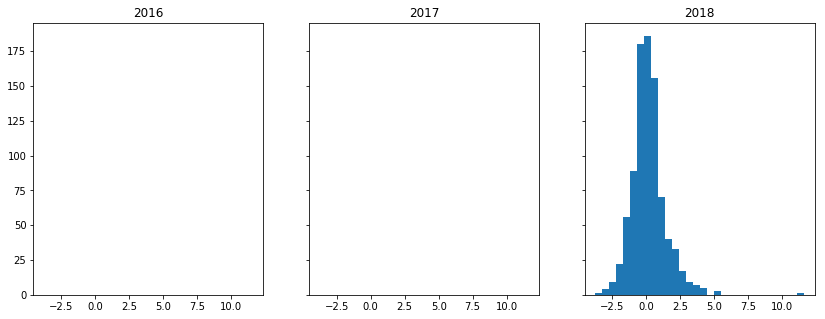

In [15]:
# Check out the distributions of loneills by MSOA
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(14,5), sharex = True, sharey=True)

#ax1.hist(msoas['loneills_2016'], bins = 30)
#ax2.hist(msoas['loneills_2017'], bins = 30)
ax3.hist(msoas['loneills_2018'], bins = 30)

ax1.set_title("2016")
ax2.set_title("2017")
ax3.set_title("2018");

In [16]:
bins = [-10, -5, -3, -2, -1, 1, 2, 3, 5, 10, 22]
labels = ['#01665e','#35978f', '#80cdc1','#c7eae5','#f5f5f5','#f6e8c3','#dfc27d','#bf812d','#8c510a','#543005']

#msoas['loneills_2016_class'] = pd.cut(msoas['loneills_2016'], bins, labels = labels)
#msoas['loneills_2017_class'] = pd.cut(msoas['loneills_2017'], bins, labels = labels)
msoas['loneills_2018_class'] = pd.cut(msoas['loneills_2018'], bins, labels = labels)

msoas['loneills_2018_class'] = msoas.loneills_2018_class.astype(str)  # convert categorical to string

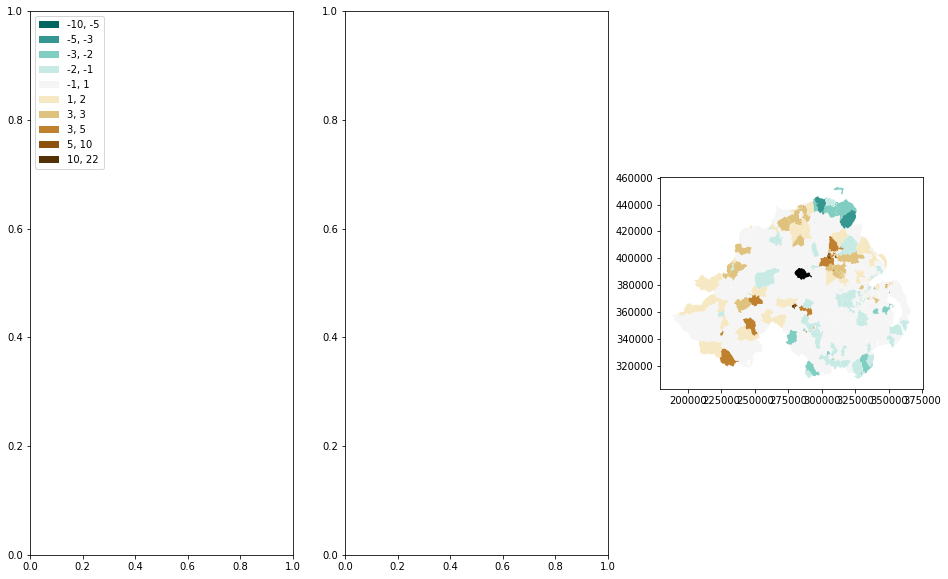

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,10))

#msoas.plot(color = msoas['loneills_2016_class'], ax=ax1)
#msoas.plot(color = msoas['loneills_2017_class'], ax=ax2)
msoas.plot(color = msoas['loneills_2018_class'], ax=ax3)

#gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax1)
#gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax2)
#gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax3)

# restrict to England
#ax1.set_xlim([82672,656000])
#ax1.set_ylim([5342,658000])
#ax2.set_xlim([82672,656000])
#ax2.set_ylim([5342,658000])
#ax3.set_xlim([82672,656000])
#ax3.set_ylim([5342,658000])

# Make a legend
# make bespoke legend
from matplotlib.patches import Patch
handles = []
ranges = ["-10, -5","-5, -3","-3, -2","-2, -1","-1, 1","1, 2","3, 3","3, 5","5, 10","10, 22"]
for color, label in zip(labels,ranges):
    handles.append(Patch(facecolor = color, label = label))

ax1.legend(handles = handles, loc = 2);

In [18]:
# Save out msoa data as shapefile and geojson
msoas.to_file(path + "msoa_loneliness.shp", driver = 'ESRI Shapefile')
#msoas.to_file(path + "msoa_loneliness.geojson", driver = 'GeoJSON')

In [19]:
# save out msoa data as csv
msoas.to_csv(path + "msoa_loneliness.csv")